![Illustration of silhouetted heads](mentalhealth.jpg)

Does going to university in a different country affect your mental health? A Japanese international university surveyed its students in 2018 and published a study the following year that was approved by several ethical and regulatory boards.

The study found that international students have a higher risk of mental health difficulties than the general population, and that social connectedness (belonging to a social group) and acculturative stress (stress associated with joining a new culture) are predictive of depression.


Let's explore the `students` data using PostgreSQL to find out if we would come to a similar conclusion for international students and see if the length of stay is a contributing factor.

Here is a data description of the columns.

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

In [52]:
-- Exploring the data
SELECT * 
FROM 'students.csv';

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24.0,4.0,5.0,Long,3.0,Average,5.0,High,None,Yes,No,No,No,0.0,Min,34.0,23.0,9.0,11.0,8.0,11.0,2.0,27.0,91.0,5.0,5.0,6.0,3.0,2.0,1.0,4.0,1.0,3.0,4.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28.0,5.0,1.0,Short,4.0,High,4.0,High,None,No,No,No,No,2.0,Min,48.0,8.0,7.0,5.0,4.0,3.0,2.0,10.0,39.0,7.0,7.0,7.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25.0,4.0,6.0,Long,4.0,High,4.0,High,Yes,Yes,No,No,No,2.0,Min,41.0,13.0,4.0,7.0,6.0,4.0,3.0,14.0,51.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,NaN,No,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29.0,5.0,1.0,Short,2.0,Low,3.0,Average,No,No,No,No,No,3.0,Min,37.0,16.0,10.0,10.0,8.0,6.0,4.0,21.0,75.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,4.0,4.0,NaN,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28.0,5.0,1.0,Short,1.0,Low,3.0,Average,Yes,No,No,No,No,3.0,Min,37.0,15.0,12.0,5.0,8.0,7.0,4.0,31.0,82.0,5.0,5.0,5.0,2.0,5.0,2.0,5.0,5.0,4.0,4.0,NaN,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46,222,None,None,None,None,None,None,None,None,None
282,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,249,None,None,None,None,None,None,None,None,None
283,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,203,None,None,None,None,None,None,None,None,None
284,None,None,None,None,NaN,NaN,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,247,None,None,None,None,None,None,None,None,None


In [53]:
-- Let's find the summary statistics for each diagnostic test using aggregate functions
SELECT ROUND (MIN (tosc), 2) AS min_phq, ROUND (MAX (tosc), 2) AS max_phq, ROUND (AVG (tosc), 2) AS avg_phq
FROM 'students.csv'

,min_phq,max_phq,avg_phq
0,8.0,48.0,37.47


In [54]:
-- Exploring the data for each student type in inter_dom and filtering for records related to international students
SELECT *
FROM 'students.csv'
WHERE inter_dom = 'Inter'

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24,4,5,Long,3,Average,5,High,None,Yes,No,No,No,0,Min,34,23,9,11,8,11,2,27,91,5,5,6,3,2,1,4,1,3,4,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28,5,1,Short,4,High,4,High,None,No,No,No,No,2,Min,48,8,7,5,4,3,2,10,39,7,7,7,4,4,4,4,1,1,1,NaN,Yes,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25,4,6,Long,4,High,4,High,Yes,Yes,No,No,No,2,Min,41,13,4,7,6,4,3,14,51,3,3,3,1,1,2,1,1,1,1,NaN,No,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29,5,1,Short,2,Low,3,Average,No,No,No,No,No,3,Min,37,16,10,10,8,6,4,21,75,5,5,5,5,5,2,2,2,4,4,NaN,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28,5,1,Short,1,Low,3,Average,Yes,No,No,No,No,3,Min,37,15,12,5,8,7,4,31,82,5,5,5,2,5,2,5,5,4,4,NaN,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Inter,SEA,Male,Under,21,3,3,Medium,4,High,4,High,Yes,Yes,No,No,No,6,Mild,37,23,8,11,8,6,4,22,82,3,2,2,2,4,2,4,2,6,4,4.0,No,No,No,No,No,No,No,No,Yes,No,No
197,Inter,SEA,Female,Under,20,2,1,Short,2,Low,4,High,Yes,No,No,No,No,7,Mild,16,29,18,17,17,12,8,44,145,7,1,3,3,4,4,4,4,7,1,4.0,Yes,No,No,No,No,No,No,No,Yes,No,No
198,Inter,SEA,Female,Under,21,3,3,Medium,2,Low,5,High,Yes,No,No,Yes,Major,16,ModSev,25,24,11,17,4,11,6,37,110,5,7,3,1,6,1,6,1,4,1,3.0,Yes,Yes,No,No,Yes,No,Yes,No,No,No,No
199,Inter,SEA,Female,Under,18,1,1,Short,1,Low,4,High,No,No,No,No,No,8,Mild,38,11,12,10,4,7,4,20,68,5,5,4,3,3,3,3,3,5,5,5.0,Yes,Yes,No,No,No,No,No,No,Yes,Yes,Yes


In [55]:
-- Calculating the count and averages for each length of stay
SELECT stay, COUNT (stay), AVG (stay)
FROM 'students.csv'
WHERE stay IS NOT NULL
GROUP BY stay
ORDER BY stay DESC

,stay,count(stay),avg(stay)
0,10,1,10.0
1,8,1,8.0
2,7,1,7.0
3,6,3,6.0
4,5,3,5.0
5,4,23,4.0
6,3,69,3.0
7,2,52,2.0
8,1,115,1.0


To analyze the data and draw conclusions about the impact of studying abroad on mental health among international students, we will consider the variables provided:

- **stay** (in years) as a measure of how long students have been in a different country,
- **count_int** as the count of international students surveyed for each year of stay,
- **average_phq** as the average score of the Patient Health Questionnaire, indicating levels of depression,
- **average_scs** as the average score of the Self-Compassion Scale, reflecting how students emotionally support themselves, and
- **average_as** as the average score of Acculturative Stress, indicating the level of stress associated with adapting to a new culture.

In [56]:
SELECT stay,
	COUNT (stay) AS count_int,
	ROUND ( AVG (todep), 2) AS average_phq,
	ROUND ( AVG (tosc), 2) AS average_scs,
	ROUND ( AVG (toas), 2) AS average_as
FROM 'students.csv'
WHERE stay IS NOT NULL
AND inter_dom = 'Inter'
GROUP BY stay
ORDER BY stay DESC

,stay,count_int,average_phq,average_scs,average_as
0,10,1,13.00,32.00,50.00
1,8,1,10.00,44.00,65.00
2,7,1,4.00,48.00,45.00
3,6,3,6.00,38.00,58.67
4,5,1,0.00,34.00,91.00
5,4,14,8.57,33.93,87.71
6,3,46,9.09,37.13,78.00
7,2,39,8.28,37.08,77.67
8,1,95,7.48,38.11,72.80


It's worth noting that there is a significant drop in the number of students who have stayed for more than 4 years, which indeed affects the reliability and interpretability of the trends for those higher stay durations. With such a small sample size for stays above 4 years, any analysis concerning these groups will be less reliable and may not accurately reflect the broader population of international students.

Given this, a more nuanced approach would be to focus on the data for stays of 4 years or less, where the population sizes are more substantial, allowing for more reliable analysis. This focus would enable us to examine trends and correlations within a more consistent sample size, potentially providing clearer insights into how the duration of stay impacts mental health indicators among international students.

Let's proceed with the analysis by computing correlations between the length of stay and each of the mental health indicators, and then visually examining these relationships.

The analysis of the data reveals several key insights into the relationship between the duration of stay in a foreign country for international students and various mental health indicators:

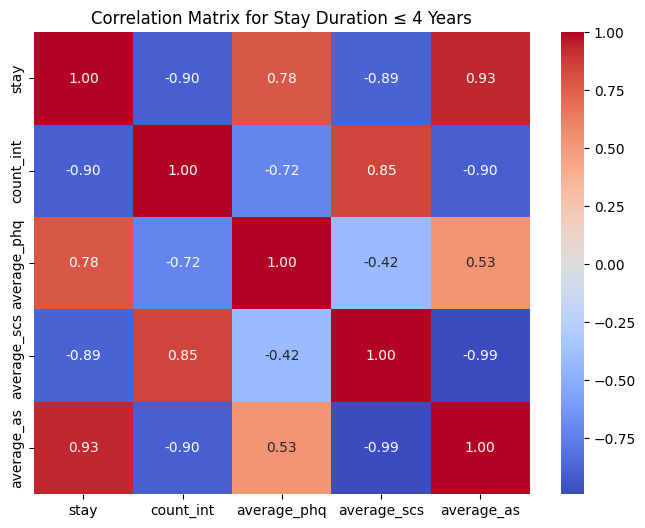

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the DataFrame with the queried data
data = {
    "stay": [10, 8, 7, 6, 5, 4, 3, 2, 1],
    "count_int": [1, 1, 1, 3, 1, 14, 46, 39, 95],
    "average_phq": [13.00, 10.00, 4.00, 6.00, 0.00, 8.57, 9.09, 8.28, 7.48],
    "average_scs": [32.00, 44.00, 48.00, 38.00, 34.00, 33.93, 37.13, 37.08, 38.11],
    "average_as": [50.00, 65.00, 45.00, 58.67, 91.00, 87.71, 78.00, 77.67, 72.80]
}
df = pd.DataFrame(data)

# Filtering the data for stay durations of 4 years or less
df_filtered = df[df['stay'] <= 4]

# Calculating correlations with the filtered data
correlations_filtered = df_filtered.corr()

# Visualization of filtered data correlations
plt.figure(figsize=(8, 6))

# Heatmap of the correlations for filtered data
sns.heatmap(correlations_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Stay Duration ≤ 4 Years')

plt.show()

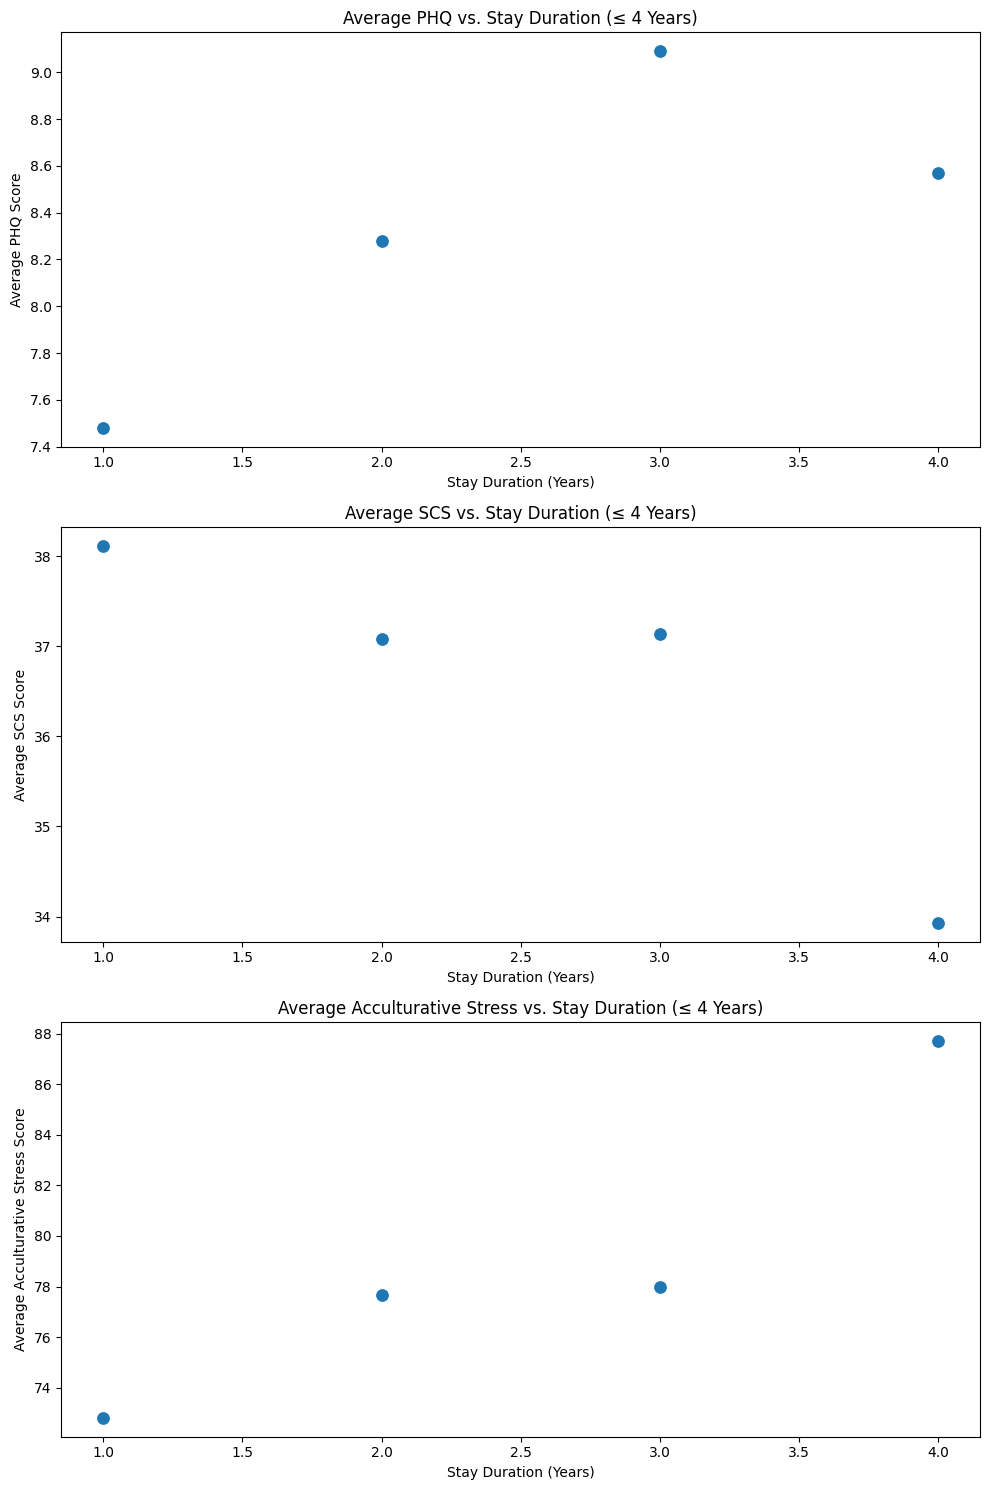

In [2]:
# Scatter plots for each mental health indicator vs. stay in the filtered dataset
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

sns.scatterplot(data=df_filtered, x='stay', y='average_phq', ax=axs[0], s=100)
axs[0].set_title('Average PHQ vs. Stay Duration (≤ 4 Years)')
axs[0].set_xlabel('Stay Duration (Years)')
axs[0].set_ylabel('Average PHQ Score')

sns.scatterplot(data=df_filtered, x='stay', y='average_scs', ax=axs[1], s=100)
axs[1].set_title('Average SCS vs. Stay Duration (≤ 4 Years)')
axs[1].set_xlabel('Stay Duration (Years)')
axs[1].set_ylabel('Average SCS Score')

sns.scatterplot(data=df_filtered, x='stay', y='average_as', ax=axs[2], s=100)
axs[2].set_title('Average Acculturative Stress vs. Stay Duration (≤ 4 Years)')
axs[2].set_xlabel('Stay Duration (Years)')
axs[2].set_ylabel('Average Acculturative Stress Score')

plt.tight_layout()
plt.show()

Key observations from the filtered dataset include:

- **Average PHQ (Depression Levels)**: There seems to be a variation in average PHQ scores with different years of stay, but with a upward trend. This suggests that while depression levels fluctuate, they worsen with longer stays.

- **Average SCS (Self-Compassion)**: The average SCS scores also vary, indicating differences in how students support themselves emotionally over different stay durations. Again, downward trend suggests that self-compassion levels decrease with the length of stay.

- **Average Acculturative Stress**: Acculturative stress levels appear to change with the duration of stay. However, like the other indicators, there is a trend showing a direct relationship between the length of stay and acculturative stress levels.

Given these observations, it's evident that the impact of studying abroad does affect your mental health. Acculturative stress is a significant factor, its effect, along with depression levels and self-compassion, follow a linear pattern over the years of stay considered. This finding underscores the need for comprehensive support systems for international students that address various aspects of mental health and well-being, regardless of how long they have been studying abroad.

The study's findings, indicating higher risks of mental health difficulties among international students compared to the general population, highlight the importance of targeted interventions. These should aim not only to reduce acculturative stress but also to enhance social connectedness and self-compassion, acknowledging that these factors play crucial roles in the mental health outcomes of international students.